c:\Users\kalog\anaconda3\envs\intership\Lib\site-packages\torch\utils\_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
c:\Users\kalog\anaconda3\envs\intership\Lib\site-packages\torch\utils\_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(


cpu
this is the label of the image below remember 
 0 = horizontal 
 1 = vertical
Epoch 1/10 - Loss: 64.8693 - Accuracy: 51.4286 %
Epoch 2/10 - Loss: 37.6165 - Accuracy: 79.8571 %
Epoch 3/10 - Loss: 13.7869 - Accuracy: 98.0000 %
Epoch 4/10 - Loss: 10.4440 - Accuracy: 99.1429 %
Epoch 5/10 - Loss: 9.9136 - Accuracy: 100.0000 %
Epoch 6/10 - Loss: 9.5069 - Accuracy: 100.0000 %
Epoch 7/10 - Loss: 9.1693 - Accuracy: 100.0000 %
Epoch 8/10 - Loss: 8.8750 - Accuracy: 100.0000 %
Epoch 9/10 - Loss: 8.5965 - Accuracy: 99.8571 %
Epoch 10/10 - Loss: 8.3316 - Accuracy: 99.1429 %


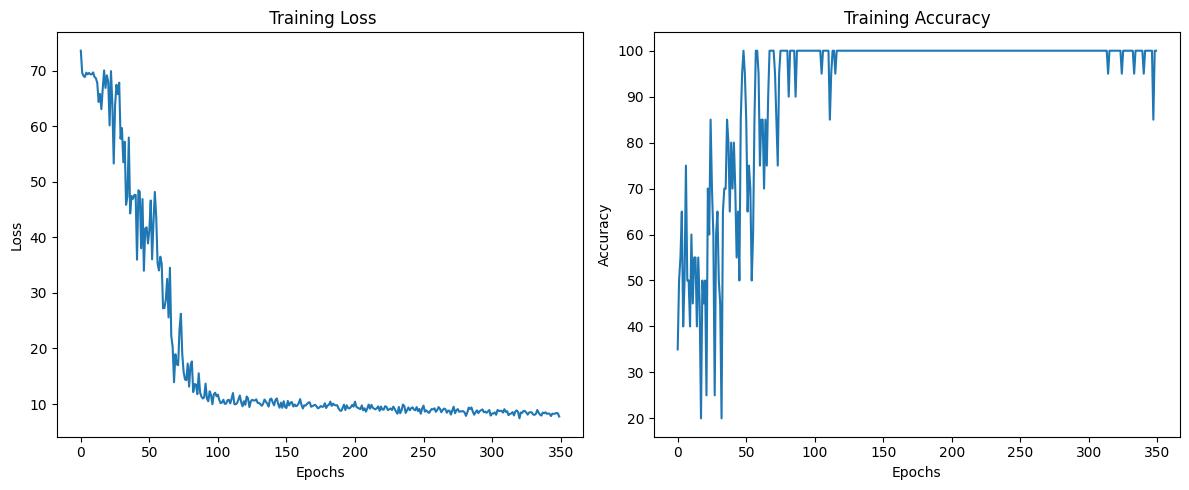

Test loss is : 0.0000 
 Accurace is : 98.67 %


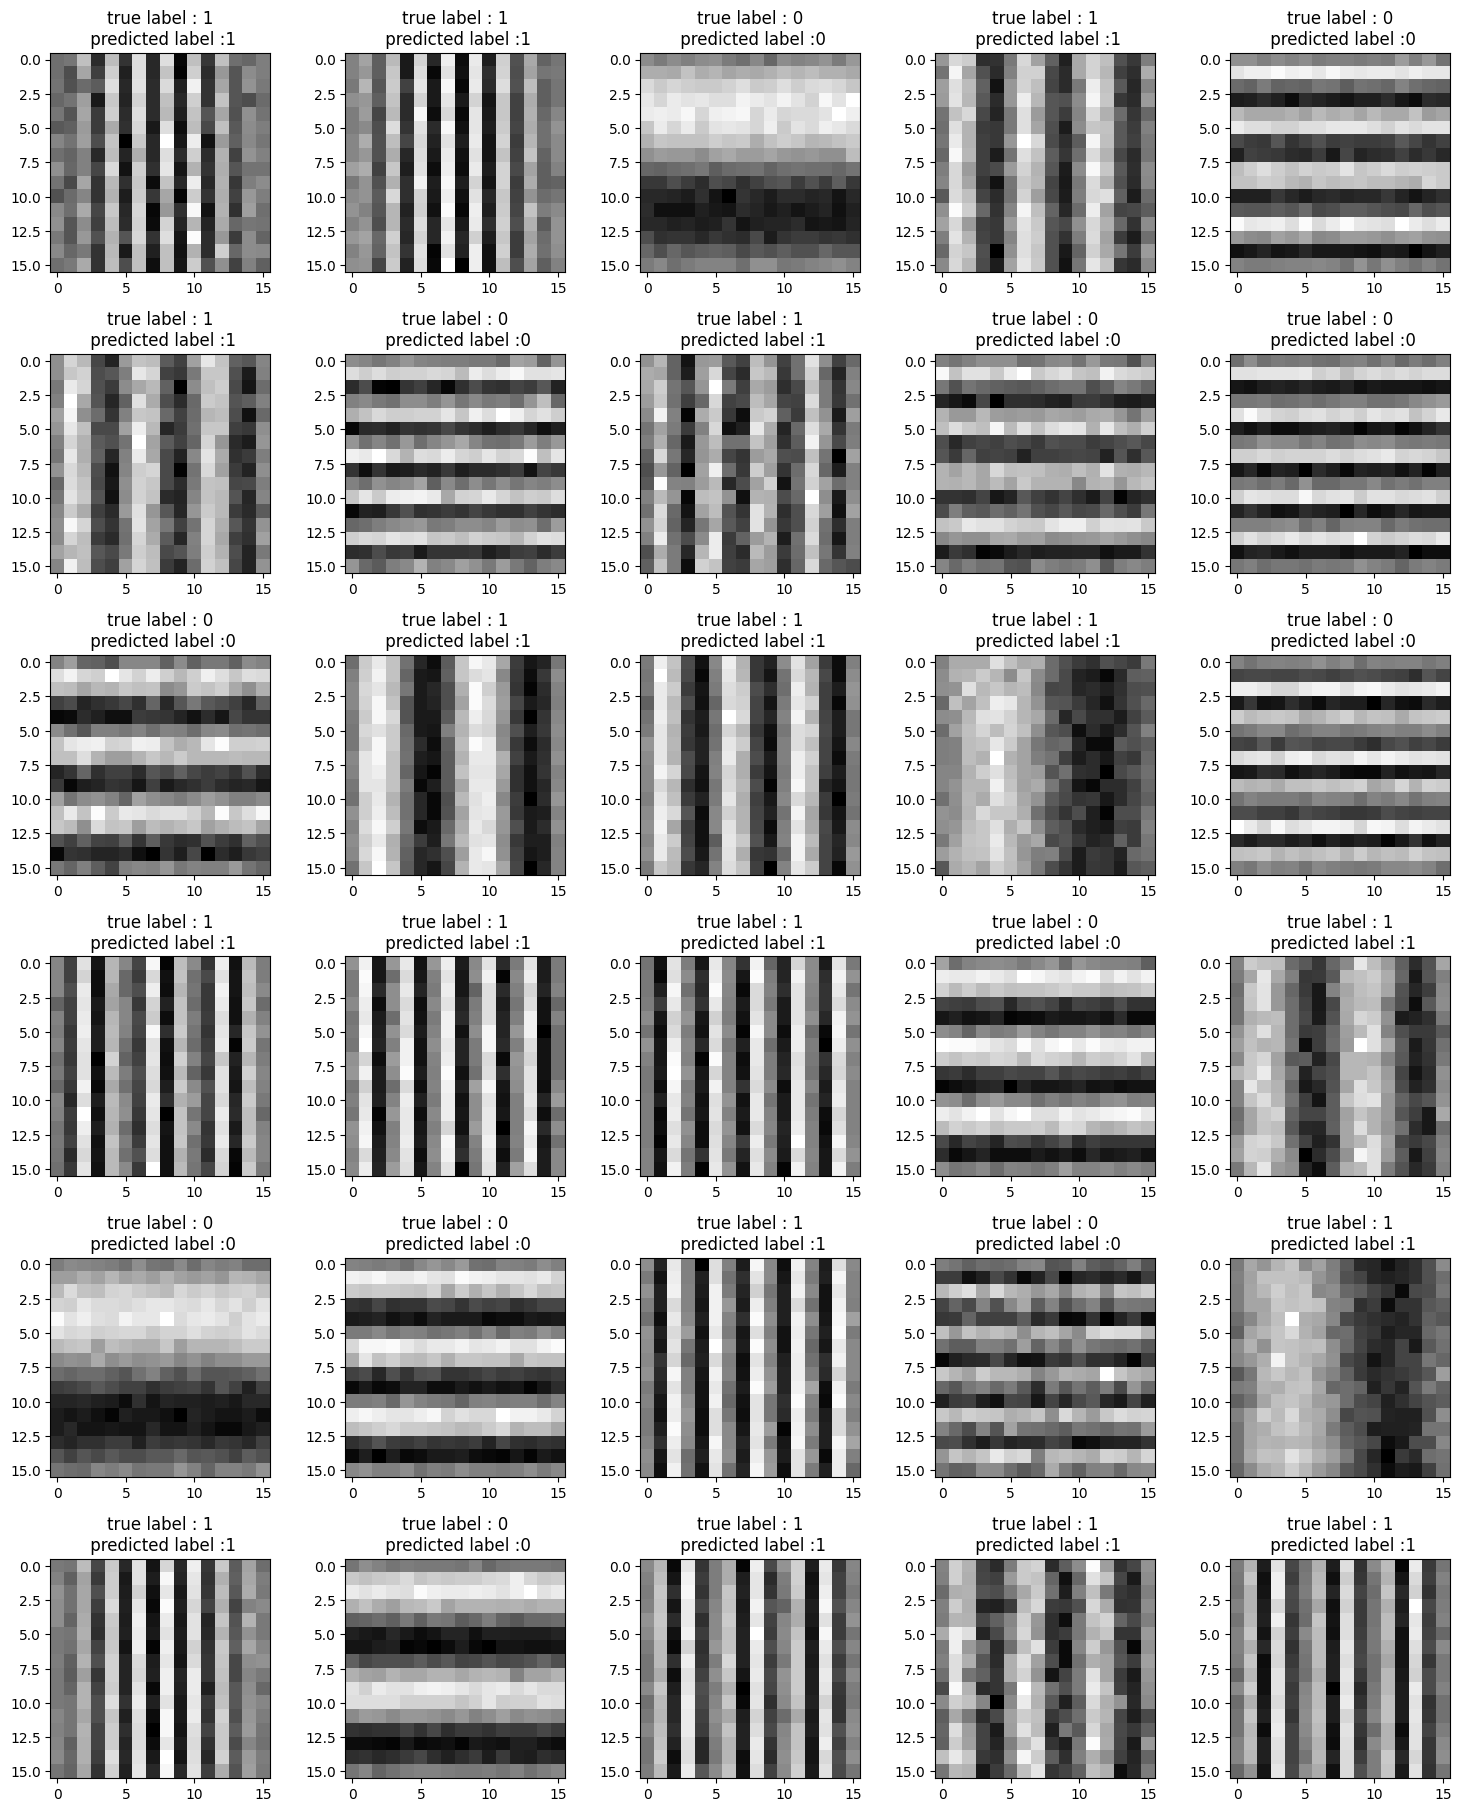

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import snntorch as snn
import torch.nn as nn
import torch.utils.data.dataloader
import torchvision
import norse.torch as norse
import torchvision.transforms as transforms
from torch.utils.data import random_split
from snntorch import surrogate
from snntorch import functional as SF

from class_dataset import CustomSinDataset


# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We can see here what device we are actually using
print(device)

#!HYPERPARAMETERS
input_size = 256  # because 16 by 16 size
hidden_size = 64  # hidden size neurons
output_size = 2  # since the number of classes is 0 and 1
batch_size = 20
num_steps = 100  # amount of steps through each epoch
epochs = 10  # the number of epochs where the model is going to be trained on
learning_rate = 0.01  # the learning rate
prcnt_of_train = 0.7
beta = 0.9  # 70% is going to be trained so input a float here

#!preparing the Data
# first we create the transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # let's only try just the ToTensors for now
        transforms.Grayscale(),  # lets also make it gray scale
        transforms.Normalize((0,), (1,)),  # and lets normalize the tensors
    ]
)

# create the train/test dataset
dataset = CustomSinDataset(
    root="../custom_dataset",
    transform=transform,
)

# Split the dataset into train and test with customizable size
train_size = int(prcnt_of_train * len(dataset))
test_size = len(dataset) - train_size

# Save them into actual train/test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

sample_data, sample_label = train_dataset[0]
# sample_label
# sample_data
# plt.imshow(sample_data[0], cmap="grey")
# print(f"Testing the dataset's size sample {sample_data.size()}")
print("this is the label of the image below remember \n 0 = horizontal \n 1 = vertical")


# And now apply the above in the Dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)


#! DEFINING THE CLASS SNN WITH CONVOLUTIONS
class SNN_MODEL(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_steps):
        super(SNN_MODEL, self).__init__()

        self.num_steps = num_steps
        self.hidden_size = hidden_size

        #!DEFINE THE LAYERS WOOHOO
        # Convolution Layer
        self.conv1 = nn.Conv2d(1, 13, 4, 1)
        # LIF Layer
        self.lif1 = norse.LIFCell(p=norse.LIFParameters(alpha=0.5))
        # Pooling layer
        self.pool1 = nn.MaxPool2d(2)
        # Convolution layer 2
        self.conv2 = nn.Conv2d(13, hidden_size, 4, 1)
        # LIF Layer 2
        self.lif2 = norse.LIFCell(p=norse.LIFParameters(alpha=0.5))
        # Befroe we move on we need to calculate the the flattened size and put that in the Linear Fc1 layer
        # after conv 1 apo 16x16 se 13x13, meta to pool1 exoume 6x6 kai meta to allo conv2 exoume 3x3
        # So we flatten the image : hidden_size * 3 * 3
        self.flattened_size = hidden_size * 3 * 3
        # Linear layer
        self.fc1 = nn.Linear(self.flattened_size, output_size)
        # LIF Layer 3
        self.lif3 = norse.LIFCell(p=norse.LIFParameters(alpha=0.5))

    #! DEFINING FORWARD
    def forward(self, x):
        batch_size = x.shape[0]  # Current batch size

        # apply first convolution to get shape for initial states
        x1 = self.conv1(x)
        x1_pooled = self.pool1(x1)  # then we pool it

        # INITIATE STATES with input tensors
        mem1 = self.lif1.initial_state(x1_pooled)

        # for the second layer, we need to apply conv2 to a tensor of the right shape
        # let's create a dummy tensor with the right shape (same shape as what spk1 would have)
        dummy_2 = self.conv2(torch.zeros_like(x1_pooled))
        mem2 = self.lif2.initial_state(dummy_2)

        # for the third layer, we need the shape after flattening
        dummy_flat = torch.zeros(batch_size, self.flattened_size)
        dummy_3 = self.fc1(dummy_flat)
        mem3 = self.lif3.initial_state(dummy_3)

        # ecord EACH layer but print only the last
        # spike record which we are going to append
        spk1_record = []
        spk2_record = []
        spk3_record = []

        # membrance record which we are going to append
        mem1_record = []
        mem2_record = []
        mem3_record = []

        # Main for loop for the steps aka time
        for step in range(self.num_steps):
            cur1 = self.conv1(x)
            cur1 = self.pool1(cur1)
            spk1, mem1 = self.lif1(
                cur1, mem1
            )  # Generating spikes and membrance voltages and storeing them in the values
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            # we flatten the spike to instert it with a dimension of 1
            flat = spk2.view(batch_size, -1)
            cur3 = self.fc1(flat)
            spk3, mem3 = self.lif3(cur3, mem3)

            # append the spikes
            spk1_record.append(spk1)
            spk2_record.append(spk2)
            spk3_record.append(spk3)

            # append the membrance voltages
            mem1_record.append(mem1.v)
            mem2_record.append(mem2.v)
            mem3_record.append(mem3.v)

        spk_out = torch.stack(spk3_record, dim=0).sum(0)
        # print(f"Shape of spk_out: {spk_out.shape}")

        return spk_out, mem3_record


#! CREATE THE MODEL
model = SNN_MODEL(input_size, hidden_size, output_size, num_steps)

#! OPTIMIZER AND CRITERION (Loss Funtion)
# defining the loss funciton
criterion = nn.CrossEntropyLoss()

# defininf the optimizer with the parameters of the model and the learning rate
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


#! DEFINING THE TRAIN FUNCTION
def train(model, train_loader, criterion, optimizer, num_steps, epochs):
    # Initialize some training metrics (loss, acc)
    loss_history = []
    acc_history = []

    # The main training loop
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.train()  # setting the mode to train
            spk_out, mem_record = model(
                inputs
            )  # receives the spike record and membrance voltage

            loss = torch.zeros((1), dtype=float, device=device)

            # for loop with the steps tha wil lcaclulate the loss
            for step in range(num_steps):
                loss += criterion(mem_record[step], labels)  # caclulates the los

            # gradient Calculation and weight update
            optimizer.zero_grad()  # MUST
            loss.backward()  # MUST
            optimizer.step()  # MUST

            # accuracy calculation
            preds = spk_out.argmax(dim=1)  # sum spikes over time
            acc = (
                preds == labels
            ).float().mean() * 100  # instead of 0.x values we get x values

            # store for plotting later maybe
            loss_history.append(loss.item())
            acc_history.append(acc.item())

            # accumulate for each epoch
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            num_batches += 1
        # Print epoch summary outside of loop
        print(
            f"Epoch {epoch + 1}/{epochs} - Loss: {(epoch_loss / num_batches):.4f} - Accuracy: {epoch_acc / num_batches:.4f} %"
        )

    plt.figure(figsize=(12, 5))

    # we need to create 2 plots one for acc and one for loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title(" Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(acc_history)
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


#! DEFINE THE TEST FUNCITON
def test(model, test_loader, num_steps):
    correct = 0
    loss = 0
    accuracy = 0
    total = 0

    # for plotting
    imgs_to_plot = []
    true_labels = []
    pred_labels = []

    # Disables gradient calculation
    with torch.no_grad():
        model.eval()

        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            test_spk, test_mem = model(data)

            _, predicted = test_spk.max(1)  # we obtain the predicted spike values

            total += labels.size(0)
            correct = correct + (predicted == labels).sum().item()

            loss += (
                criterion(test_mem[num_steps - 1], labels).item()
            )  # update the loss based on the last value ofthe spiking membrance voltage

            # Save 2 images from each batch to plot and see the prediction
            for i in range(min(2, data.size(0))):
                img = data[i].squeeze().numpy()
                imgs_to_plot.append(img)  # we remove the 1 greyscale channel
                true_labels.append(labels[i].item())
                pred_labels.append(predicted[i].item())

    avg_loss = loss / len(test_loader)
    accuracy = 100 * (correct / total)

    print(f"Test loss is : {(avg_loss):.4f} \n Accurace is : {(accuracy):.2f} %")

    # we are going to plot the images with the true labels and the predicted ones
    num_images = len(imgs_to_plot)
    columns = 5
    rows = round((num_images + columns) // columns)

    plt.figure(figsize=(15, rows * 3))

    for idx, img in enumerate(imgs_to_plot):
        plt.subplot(rows, columns, idx + 1)
        plt.imshow(img, cmap="gray")
        plt.title(
            f"true label : {true_labels[idx]}\n predicted label :{pred_labels[idx]}"
        )
        plt.tight_layout()
    plt.show()


#! TRAIN THE MODEL
train(model, train_loader, criterion, optimizer, num_steps, epochs)

#!TEST THE MODEL
test(model, test_loader, num_steps)

#! SOME PLOTTING
#! TEST SOME SAMPLES